<a href="https://colab.research.google.com/github/alkindiisda/Bangkit-YOG3-C/blob/master/real_vs_fake_face(densenet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I already saved necessary dataset for this notebook on my google drive.

check 'save_dataset_to_drive.ipynb' on https://github.com/alkindiisda/Bangkit-YOG3-C how to do it



In [0]:
import os
import numpy as np
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(tf.__version__)

2.2.0


In [0]:
# Mount Google Drive to Colab (I'm using the dataset on my drive)
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Preprocessing



In [0]:
import zipfile

local_zip = '/gdrive/My Drive/140k-real-and-fake-faces.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

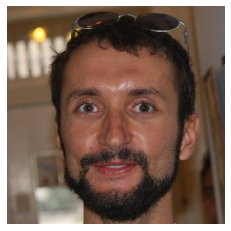

(256, 256, 3)


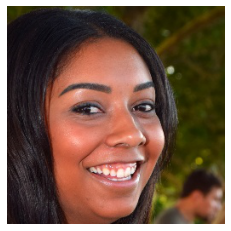

(256, 256, 3)


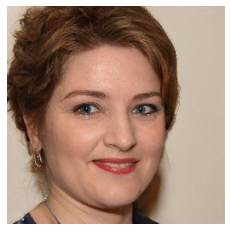

(256, 256, 3)


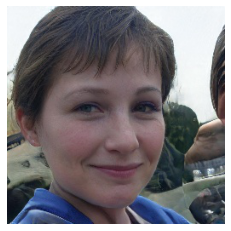

(256, 256, 3)


In [0]:
base_dir = '/content/real_vs_fake/real-vs-fake' # Change the path based on your directory

test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

# Let's print some images
test_real_dir = os.path.join(test_dir, 'real')
test_fake_dir = os.path.join(test_dir, 'fake')

test_real_fnames = os.listdir(test_real_dir)
test_fake_fnames = os.listdir(test_fake_dir)

# First 2 images is real faces and next 2 is fake faces
real_face = [os.path.join(test_real_dir, fname) for fname in test_real_fnames[:2]]
fake_face = [os.path.join(test_fake_dir, fname) for fname in test_fake_fnames[:2]]

for i, img_path in enumerate(real_face + fake_face):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  print(np.shape(img))

In [0]:
image_datagen = ImageDataGenerator(rescale = 1.0/255.0,)

train_generator = image_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(150, 150),
    class_mode='binary'
)

valid_generator = image_datagen.flow_from_directory(
    valid_dir,
    batch_size=64,
    target_size=(150, 150),
    class_mode='binary'
)

test_generator = image_datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(150, 150),
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Train Model
Densenet

In [0]:
local_zip = '/gdrive/My Drive/densenet/densenet-keras.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [0]:
densenet = tf.keras.applications.DenseNet121(
    weights='/content/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(150, 150, 3)
)

model = tf.keras.models.Sequential([
    densenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [0]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=train_steps,
    validation_data=valid_generator,
    validation_steps=valid_steps
)

Epoch 1/5
1562/1562 [==============================] - 383s 245ms/step - loss: 0.1827 - accuracy: 0.9244 - val_loss: 0.1951 - val_accuracy: 0.9336
Epoch 2/5
1562/1562 [==============================] - 327s 209ms/step - loss: 0.0762 - accuracy: 0.9714 - val_loss: 0.1252 - val_accuracy: 0.9540
Epoch 3/5
1562/1562 [==============================] - 326s 209ms/step - loss: 0.0541 - accuracy: 0.9799 - val_loss: 0.1553 - val_accuracy: 0.9408
Epoch 4/5
1562/1562 [==============================] - 325s 208ms/step - loss: 0.0414 - accuracy: 0.9846 - val_loss: 0.1154 - val_accuracy: 0.9536
Epoch 5/5
1562/1562 [==============================] - 326s 209ms/step - loss: 0.0328 - accuracy: 0.9880 - val_loss: 0.0705 - val_accuracy: 0.9754


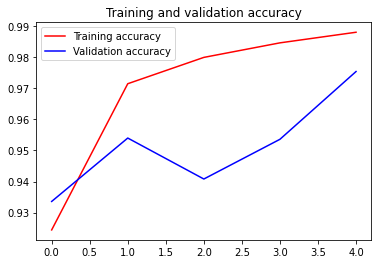

<Figure size 432x288 with 0 Axes>

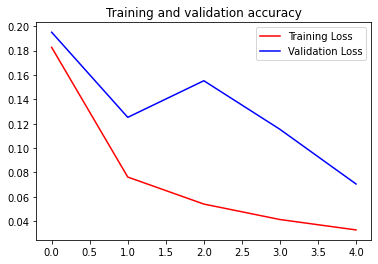

<Figure size 432x288 with 0 Axes>

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt_acc = plt.plot(epochs, acc, 'r', label='Training accuracy')
plt_acc = plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt_acc = plt.title('Training and validation accuracy')
plt_acc = plt.legend(loc=0)
plt.acc = plt.figure()

plt.show(plt_acc)

plt_loss = plt.plot(epochs, loss, 'r', label='Training Loss')
plt_loss = plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt_loss = plt.title('Training and validation accuracy')
plt_loss = plt.legend(loc=0)
plt_loss = plt.figure()

plt.show(plt_loss)

# Save Model

In [0]:
model_dir = '/gdrive/My Drive/final_project_models'
version = 'densenet'

export_path = os.path.join(model_dir, version)
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)


export_path = /gdrive/My Drive/final_project_models/densenet

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /gdrive/My Drive/final_project_models/densenet/assets


# Evaluation

In [0]:
#model = tf.keras.models.load_model(export_path)

In [0]:
test_steps = 20000//64

model.evaluate(test_generator, steps=test_steps)

312/312 [==============================] - 53s 170ms/step - loss: 0.0713 - accuracy: 0.9773


[0.07130137085914612, 0.9773136973381042]